# This notebook examines the effect of gene mutation on phosphorylation levels in various proteins.

In this notebook, we look at the proteins ARID1A, AHNAK, KMT2D, FLNA, ADD3, and CTNNB1 and examine the result of mutation in their coding gene on the protein's phosphorylation level. We do this by creating a dataframe, using the CPTAC package, in which all of the protein's phosphorylation sites and levels at that site are displayed, along with with the gene mutation status. We then sort this dataframe into two groups, mutated and wildtype. We do a t-test to compare the two groups, and record the p-value of the test. Next, we select the 5 most statistically significant p-values, and create a plot of these 5 sites, showing the difference in phosphorylation levels at that site, comparing mutated and wildtype in the gene.

##### Import the necessary python packages, including the CPTAC endometrial dataset

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.stats.multitest
import CPTAC.Endometrial as CPTAC

Welcome to the CPTAC data service package. This import contains
information about the package. In order to access a specific data set,
import a CPTAC subfolder by either 'import CPTAC.DataName' or 'from
CPTAC import DataName'.
Loading Endometrial CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter embargo() to open the webpage for more details.


##### Get the relevant data from CPTAC, including phosphorylation data

In [2]:
'''Get phosphorylation levels data'''
phos = CPTAC.get_phosphoproteomics()

## ARID1A

##### 1. Look at the ARID1A gene, and the effect of its mutation on phosphorylation levels in the ARID1A Protein. Use the CPTAC compare mutations method to see how phosphorylation levels at each site are affected by ARID1A mutation. 

In [3]:
gene = 'ARID1A'
prot = 'ARID1A'

genedf = CPTAC.compare_mutations(phos, prot, gene)

##### 2. Make a list of all the phosphorylation sites on ARID1A. 

In [4]:
p_val_dict = {}
siteList = []

'''Make a list of all sites with the associated protein'''
for colName in genedf:
    if colName != "Mutation" and colName != "Patient_Type":
        siteList.append(colName)

##### 3. For each phosphorylation site in ARID1A, seperate the dataframe into a mutated and wildtype group. do a t-test to compare the phosphorylation levels at the site when ARID1A is mutated vs when it is not. Keep track of this p-value in a dictionary.

In [5]:
'''Do a t-test on each site, comparing mutated vs wildtype phosphorylation levels'''
for site in siteList:
    '''Use CPTAC compare mutations to examine phosphorylation levels at the site when gene is mutated'''
    phosdf = CPTAC.compare_mutations(phos, site, gene)
    '''Look at only the tumor patient types'''
    phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1).dropna()
    '''Split dataframe into mutated and wildtype groups'''
    mutateddf = phosdf.loc[phosdf['Mutation'] != 'Wildtype']
    wtdf = phosdf.loc[phosdf['Mutation'] == 'Wildtype']
    '''Do a t-test to compare the phosphorylation levels in the mutated and wildtype groups'''
    ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
    p_val_dict[site] = ttest[1]   

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


##### 4. Remove nan p-values from our p-value dictionary. (This eliminates phosphorylation sites that had high number of nan values)

In [6]:
'''Remove nan p-values'''
for key in list(p_val_dict.keys()):
    if np.isnan(p_val_dict[key]):
        del p_val_dict[key]

##### 5. Sort the p-value dictionary, putting the most significant p-values first

In [7]:
'''Sort the dictionary for most significant p-values'''
sorted_dict = dict(sorted(p_val_dict.items(), key=lambda kv: kv[1]))
#print(sorted_dict)

##### 6. Grab the 5 most significant sites (the phosphorylation sites in ARID1A where phosphorylation levels were most significantly different between mutated and wildtype, based on p-value).

In [8]:
'''Get the 5 most significant sites'''
five_most_sig_sites = []
for key in sorted_dict.keys():
    five_most_sig_sites.append(key)
five_most_sig_sites = five_most_sig_sites[:5]
#print(five_most_sig_sites)

##### 7. Add these 5 most significant sites to a dataframe, in order to compare mutated and wildtype in these sites

In [9]:
'''Make a dataframe showing phosphorylation levels at these 5 sites, comparing mutated vs wildtype'''
plotdf = CPTAC.compare_mutations(phos, gene)
plotdf = plotdf.loc[plotdf['Patient_Type'] == 'Tumor'][['Mutation']]
for site in five_most_sig_sites:
    pdf = CPTAC.compare_mutations(phos, site, gene)[[site]]
    #print(proteindf)
    plotdf = plotdf.join(pdf)

##### 8. Reformat the dataframe, changing all mutation types to simply read "mutation", so we can compare mutation with wildtype, and see the difference in phosphorylation levels.

In [10]:
'''Make all mutations read "mutation", to compare with wildtype'''
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Mutation',
                                      'Frame_Shift_Ins': 'Mutation',
                                      'Splice_Site' : 'Mutation',
                                      'In_Frame_Del' : 'Mutation',
                                      'Nonsense_Mutation': 'Mutation',
                                      'Missense_Mutation': 'Mutation'
                                     }})

##### 9. Reformat the data to plot it using our plotting libraries

In [11]:
'''Reformat dataframe to plot'''
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Site', value_name='Phosphorylation')
plotdf = plotdf.dropna(axis=0)
#print(plotdf)

##### 10. Plot the data in our dataframe, showing the difference in phosphorylation levels of the 5 most significant sites in our protein, comparing mutated with wildtype.

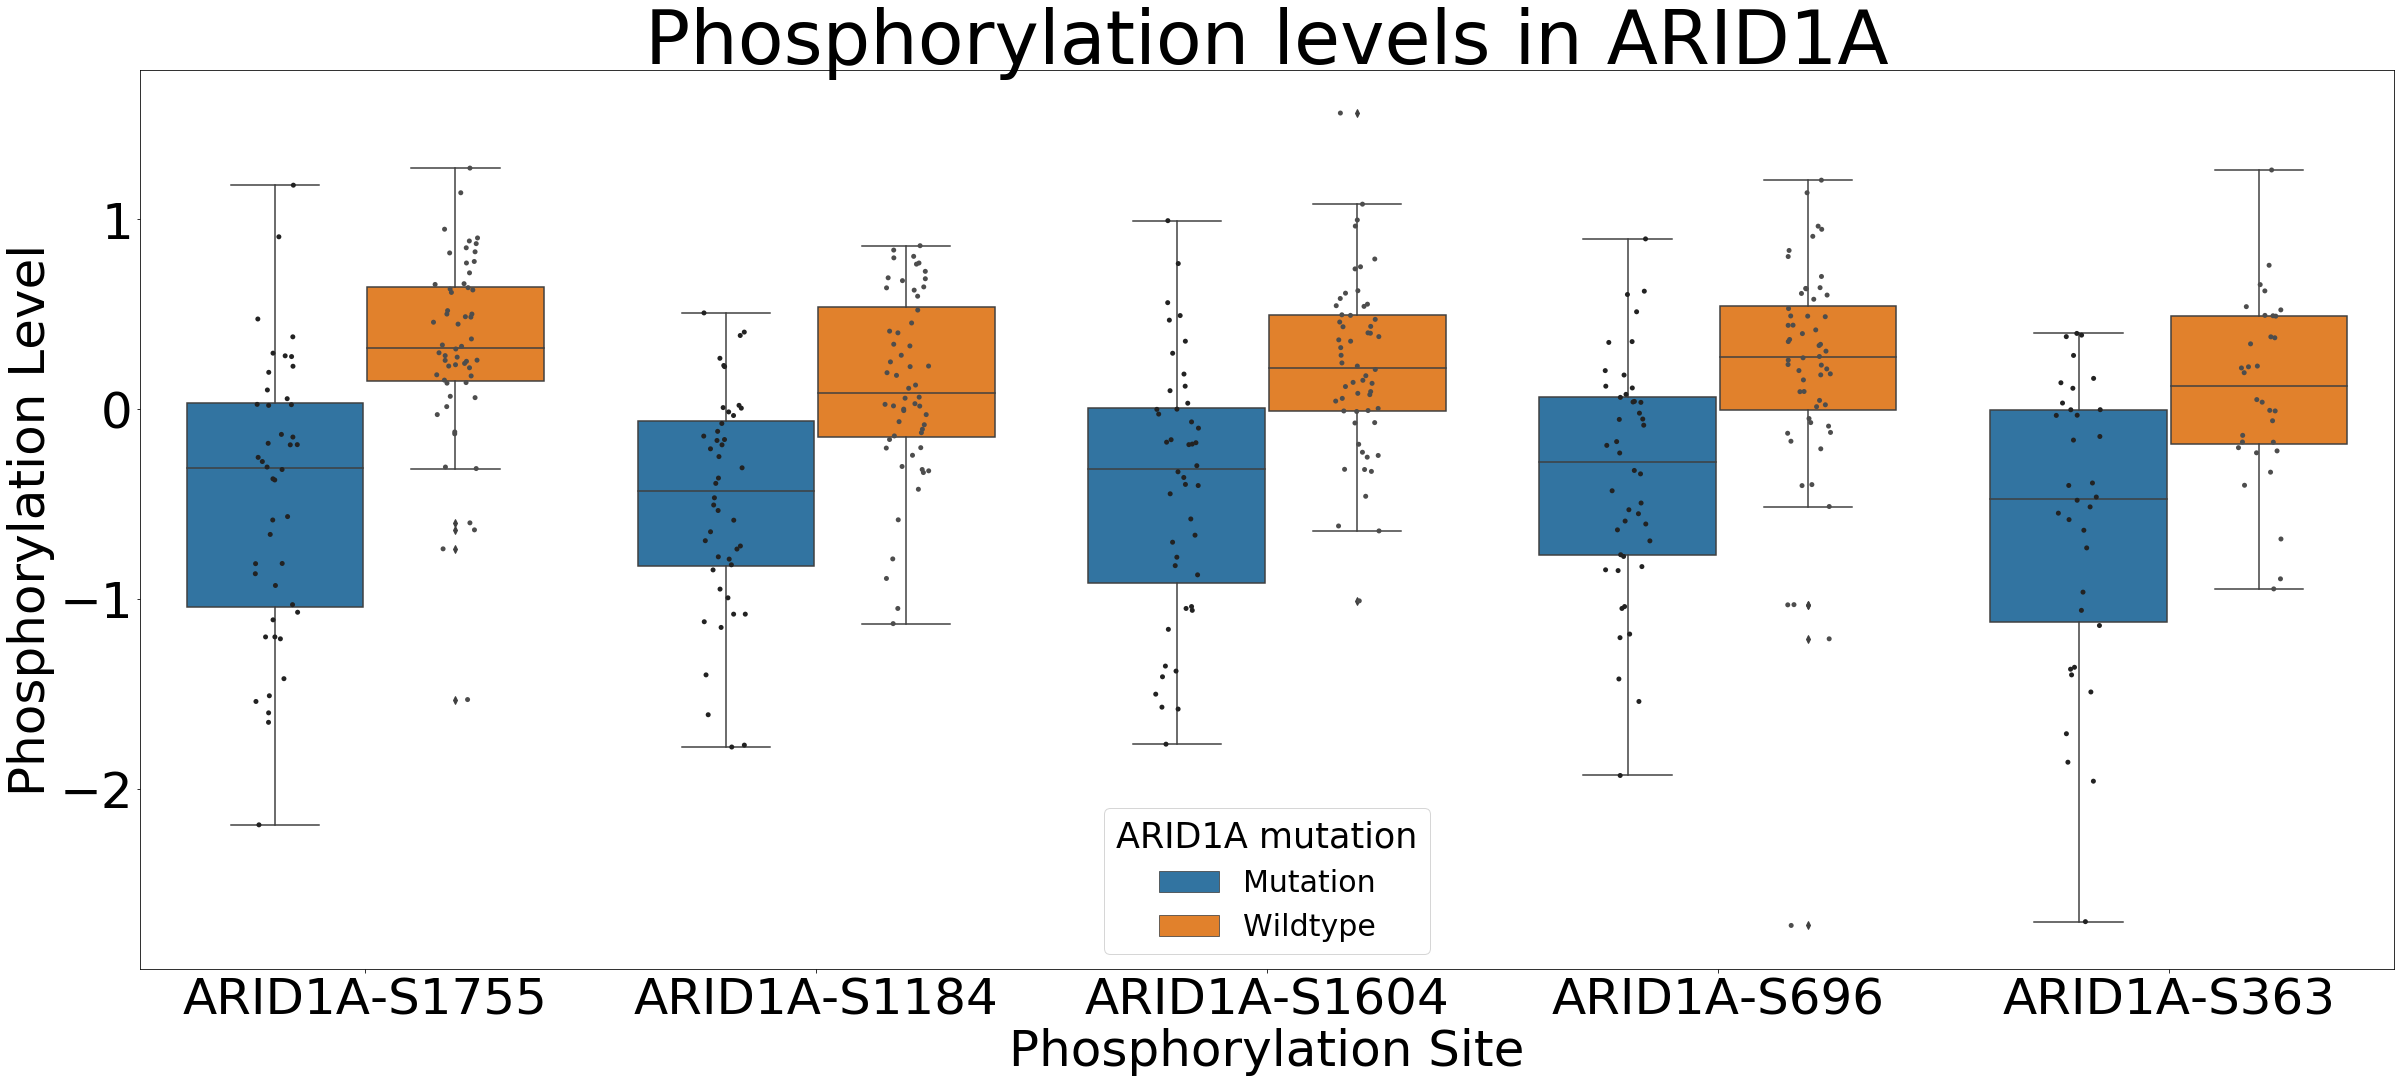

In [12]:
'''plot data'''
a4_dims = (40.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
boxplt = sns.boxplot(x='Site', y='Phosphorylation', hue='Mutation', data=plotdf)
boxplt = sns.stripplot(data=plotdf, x='Site', y='Phosphorylation', hue='Mutation', dodge=True, jitter=True, color='.3')

boxplt.set_xlabel('Phosphorylation Site', fontsize='50')
boxplt.set_ylabel('Phosphorylation Level', fontsize='50')
boxplt.tick_params(labelsize='50')
boxplt.set_title('Phosphorylation levels in ' + gene, fontsize = '75')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2],labels[0:2],title=gene + ' mutation', fontsize='30')
boxplt.get_legend().get_title().set_fontsize('35')

# NOTE: All remaining proteins are examined, and plots created, following the exact same steps as outlined above.

## AHNAK

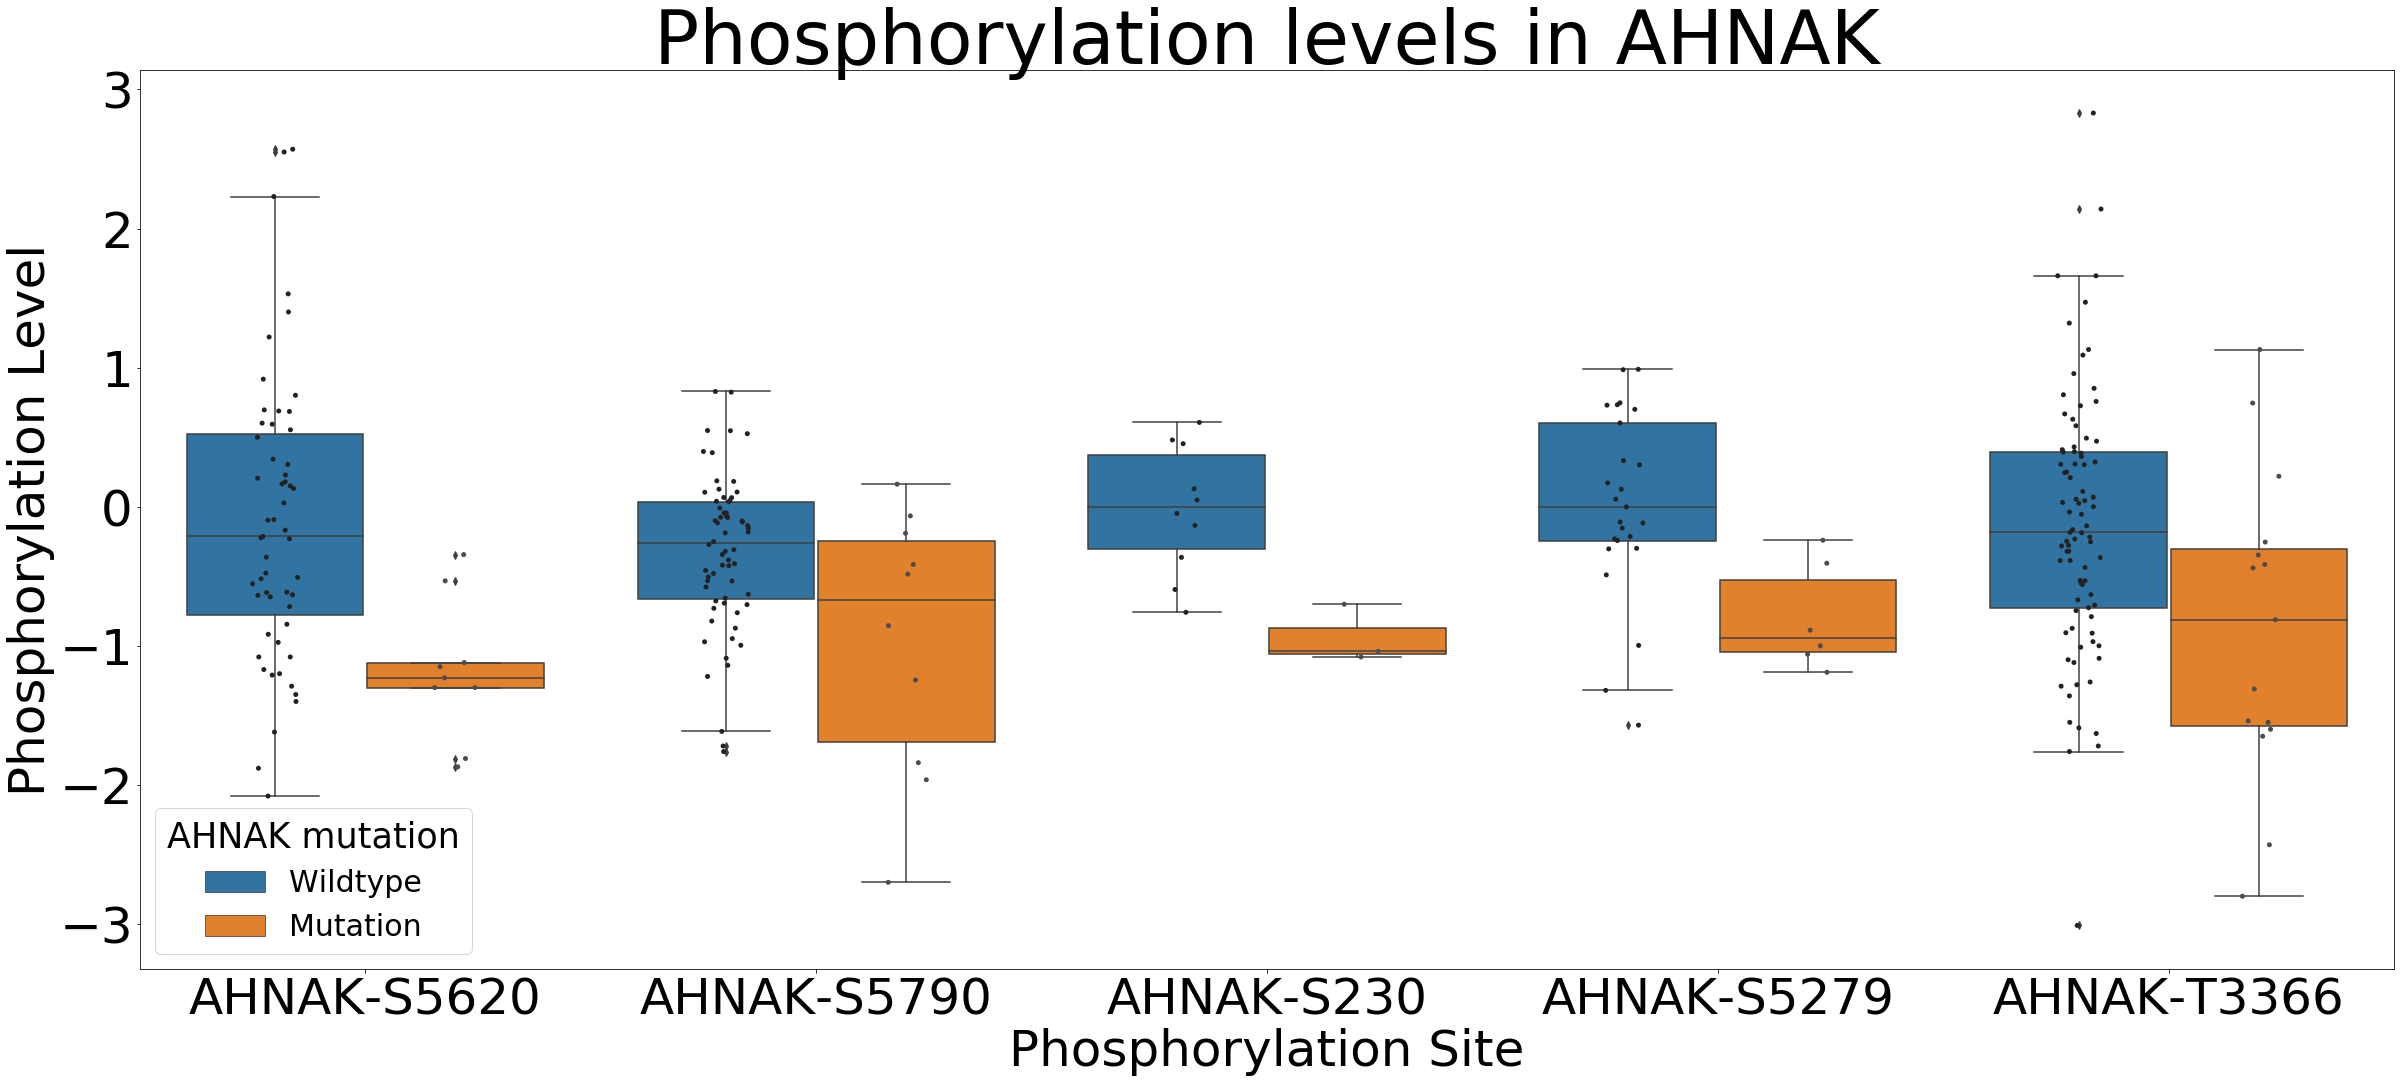

In [13]:
gene = 'AHNAK'
prot = 'AHNAK'

genedf = CPTAC.compare_mutations(phos, prot, gene)

p_val_dict = {}
siteList = []

'''Make a list of all sites with the associated protein'''
for colName in genedf:
    if colName != "Mutation" and colName != "Patient_Type":
        siteList.append(colName)


'''Do a t-test on each site, comparing mutated vs wildtype phosphorylation levels'''
for site in siteList:
    phosdf = CPTAC.compare_mutations(phos, site, gene)
    phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1).dropna()
    #print(phosdf)
    mutateddf = phosdf.loc[phosdf['Mutation'] != 'Wildtype']
    wtdf = phosdf.loc[phosdf['Mutation'] == 'Wildtype']
    ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
    p_val_dict[site] = ttest[1]   
#print(p_val_dict)

'''Remove nan p-values'''
for key in list(p_val_dict.keys()):
    if np.isnan(p_val_dict[key]):
        del p_val_dict[key]
        

'''Sort the dictionary for most significant p-values'''
sorted_dict = dict(sorted(p_val_dict.items(), key=lambda kv: kv[1]))
#print(sorted_dict)


'''Get the 5 most significant sites'''
five_most_sig_sites = []
for key in sorted_dict.keys():
    five_most_sig_sites.append(key)
five_most_sig_sites = five_most_sig_sites[:5]
#print(five_most_sig_sites)


'''Make a dataframe showing phosphorylation levels at these 5 sites, comparing mutated vs wildtype'''
plotdf = CPTAC.compare_mutations(phos, gene)
plotdf = plotdf.loc[plotdf['Patient_Type'] == 'Tumor'][['Mutation']]
for site in five_most_sig_sites:
    pdf = CPTAC.compare_mutations(phos, site, gene)[[site]]
    #print(proteindf)
    plotdf = plotdf.join(pdf)


'''Make all mutations read "mutation", to compare with wildtype'''
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Mutation',
                                      'Frame_Shift_Ins': 'Mutation',
                                      'Splice_Site' : 'Mutation',
                                      'In_Frame_Del' : 'Mutation',
                                      'Nonsense_Mutation': 'Mutation',
                                      'Missense_Mutation': 'Mutation'
                                     }})
    
'''Reformat dataframe to plot'''
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Site', value_name='Phosphorylation')
plotdf = plotdf.dropna(axis=0)
#print(plotdf)

'''Plot data'''
a4_dims = (40.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
boxplt = sns.boxplot(x='Site', y='Phosphorylation', hue='Mutation', data=plotdf)
boxplt = sns.stripplot(data=plotdf, x='Site', y='Phosphorylation', hue='Mutation', dodge=True, jitter=True, color='.3')

boxplt.set_xlabel('Phosphorylation Site', fontsize='50')
boxplt.set_ylabel('Phosphorylation Level', fontsize='50')
boxplt.tick_params(labelsize='50')
boxplt.set_title('Phosphorylation levels in ' + gene, fontsize = '75')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2],labels[0:2],title=gene + ' mutation', fontsize='30')
boxplt.get_legend().get_title().set_fontsize('35')


## KMT2D

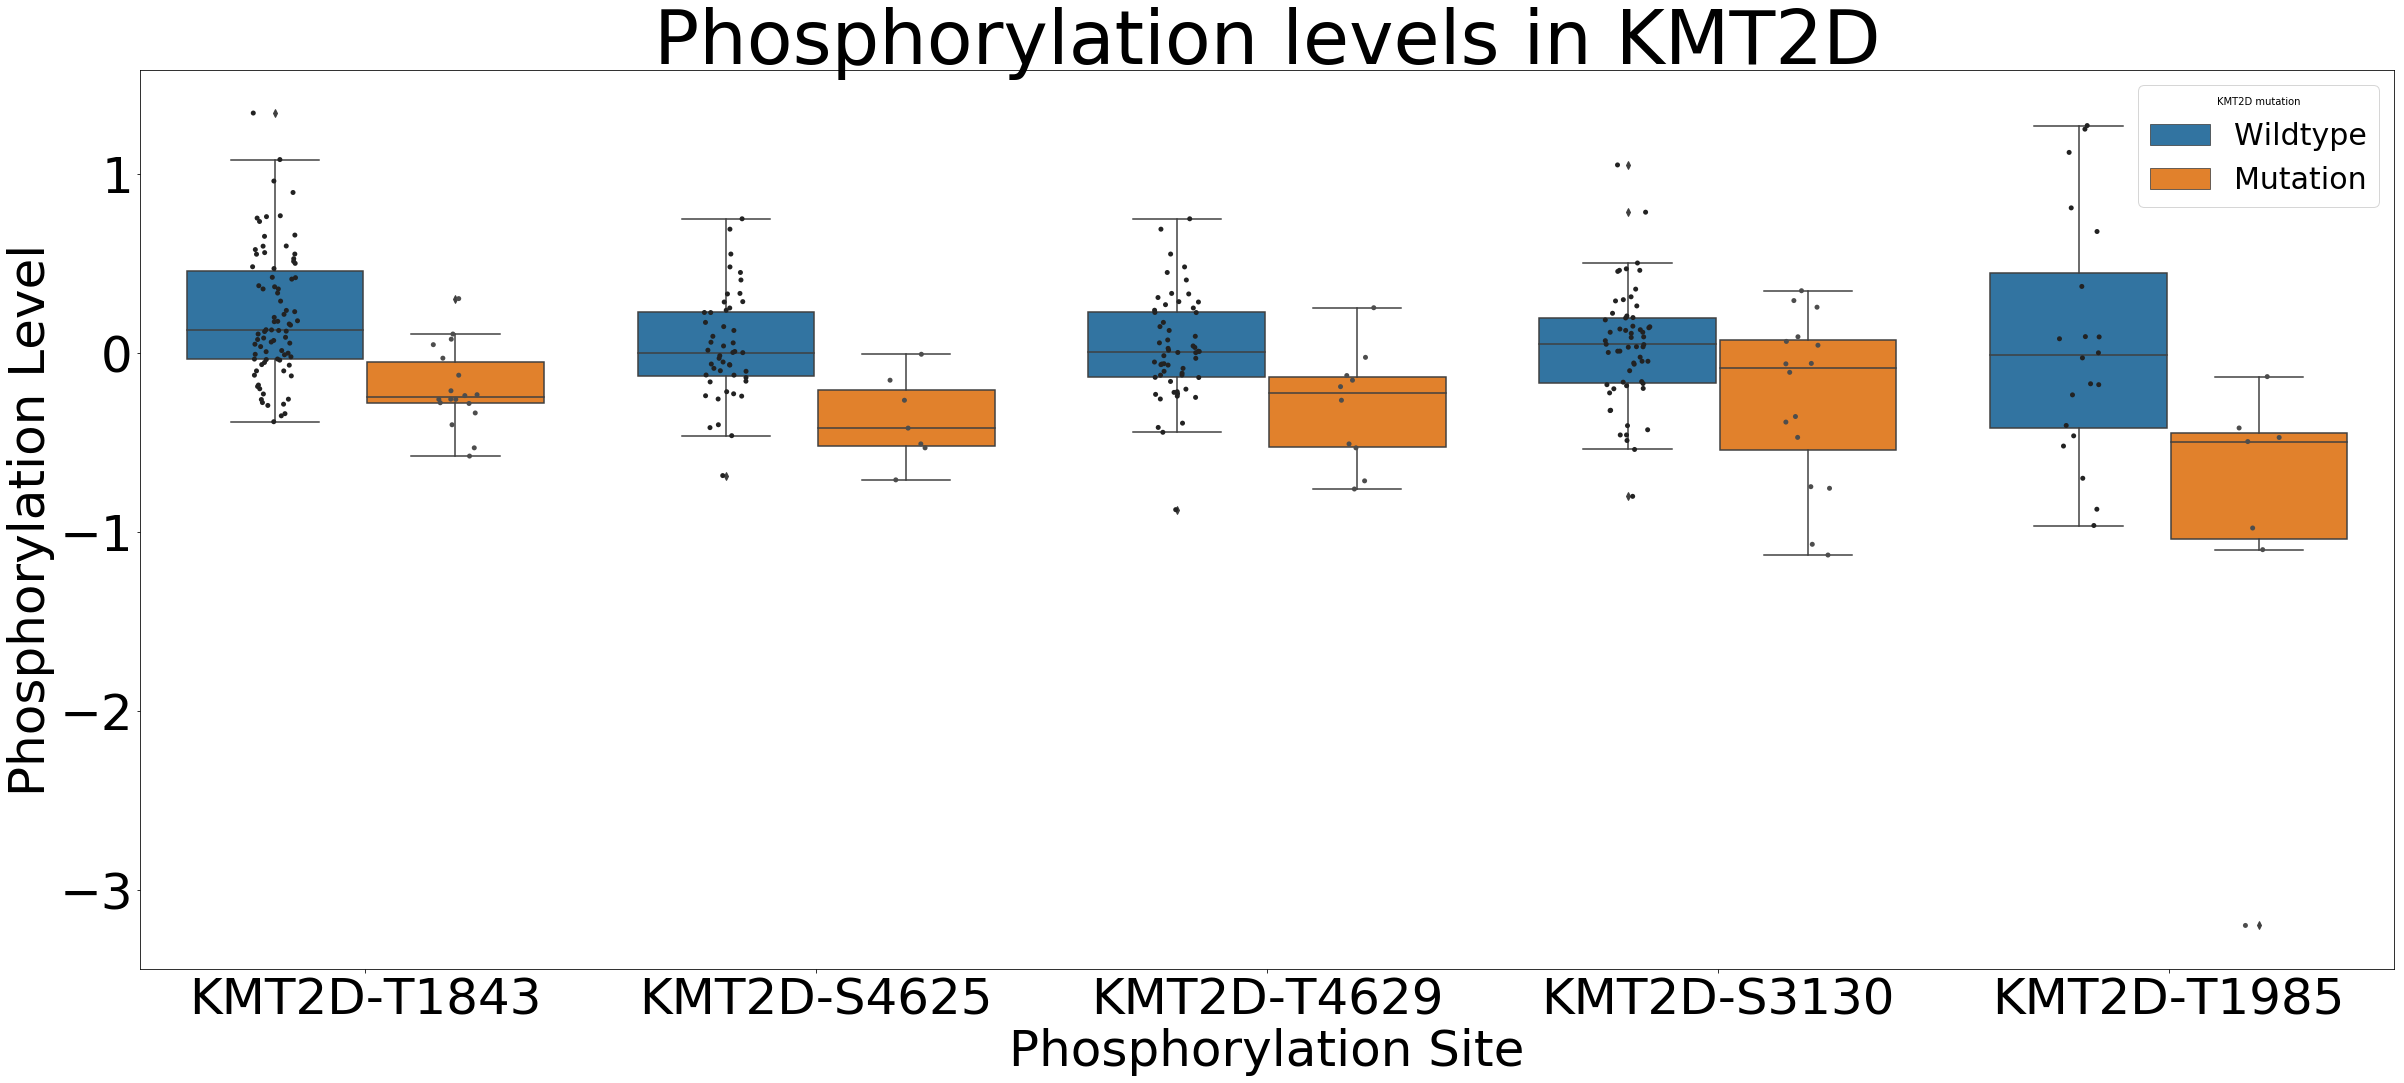

In [14]:
gene = 'KMT2D'
prot = 'KMT2D'

genedf = CPTAC.compare_mutations(phos, prot, gene)

p_val_dict = {}
siteList = []

'''Make a list of all sites with the associated protein'''
for colName in genedf:
    if colName != "Mutation" and colName != "Patient_Type":
        siteList.append(colName)


'''Do a t-test on each site, comparing mutated vs wildtype phosphorylation levels'''
for site in siteList:
    phosdf = CPTAC.compare_mutations(phos, site, gene)
    phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1).dropna()
    #print(phosdf)
    mutateddf = phosdf.loc[phosdf['Mutation'] != 'Wildtype']
    wtdf = phosdf.loc[phosdf['Mutation'] == 'Wildtype']
    ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
    p_val_dict[site] = ttest[1]   
#print(p_val_dict)

'''Remove nan p-values'''
for key in list(p_val_dict.keys()):
    if np.isnan(p_val_dict[key]):
        del p_val_dict[key]
        

'''Sort the dictionary for most significant p-values'''
sorted_dict = dict(sorted(p_val_dict.items(), key=lambda kv: kv[1]))
#print(sorted_dict)


'''Get the 5 most significant sites'''
five_most_sig_sites = []
for key in sorted_dict.keys():
    five_most_sig_sites.append(key)
five_most_sig_sites = five_most_sig_sites[:5]
#print(five_most_sig_sites)


'''Make a dataframe showing phosphorylation levels at these 5 sites, comparing mutated vs wildtype'''
plotdf = CPTAC.compare_mutations(phos, gene)
plotdf = plotdf.loc[plotdf['Patient_Type'] == 'Tumor'][['Mutation']]
for site in five_most_sig_sites:
    pdf = CPTAC.compare_mutations(phos, site, gene)[[site]]
    #print(proteindf)
    plotdf = plotdf.join(pdf)


'''Make all mutations read "mutation", to compare with wildtype'''
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Mutation',
                                      'Frame_Shift_Ins': 'Mutation',
                                      'Splice_Site' : 'Mutation',
                                      'In_Frame_Del' : 'Mutation',
                                      'Nonsense_Mutation': 'Mutation',
                                      'Missense_Mutation': 'Mutation'
                                     }})
    
'''Reformat dataframe to plot'''
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Site', value_name='Phosphorylation')
plotdf = plotdf.dropna(axis=0)
#print(plotdf)

'''Plot data'''
a4_dims = (40.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
boxplt = sns.boxplot(x='Site', y='Phosphorylation', hue='Mutation', data=plotdf)
boxplt = sns.stripplot(data=plotdf, x='Site', y='Phosphorylation', hue='Mutation', dodge=True, jitter=True, color='.3')

boxplt.set_xlabel('Phosphorylation Site', fontsize='50')
boxplt.set_ylabel('Phosphorylation Level', fontsize='50')
boxplt.tick_params(labelsize='50')
boxplt.set_title('Phosphorylation levels in ' + gene, fontsize = '75')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2],labels[0:2],title=gene + ' mutation', fontsize='30')

## FLNA

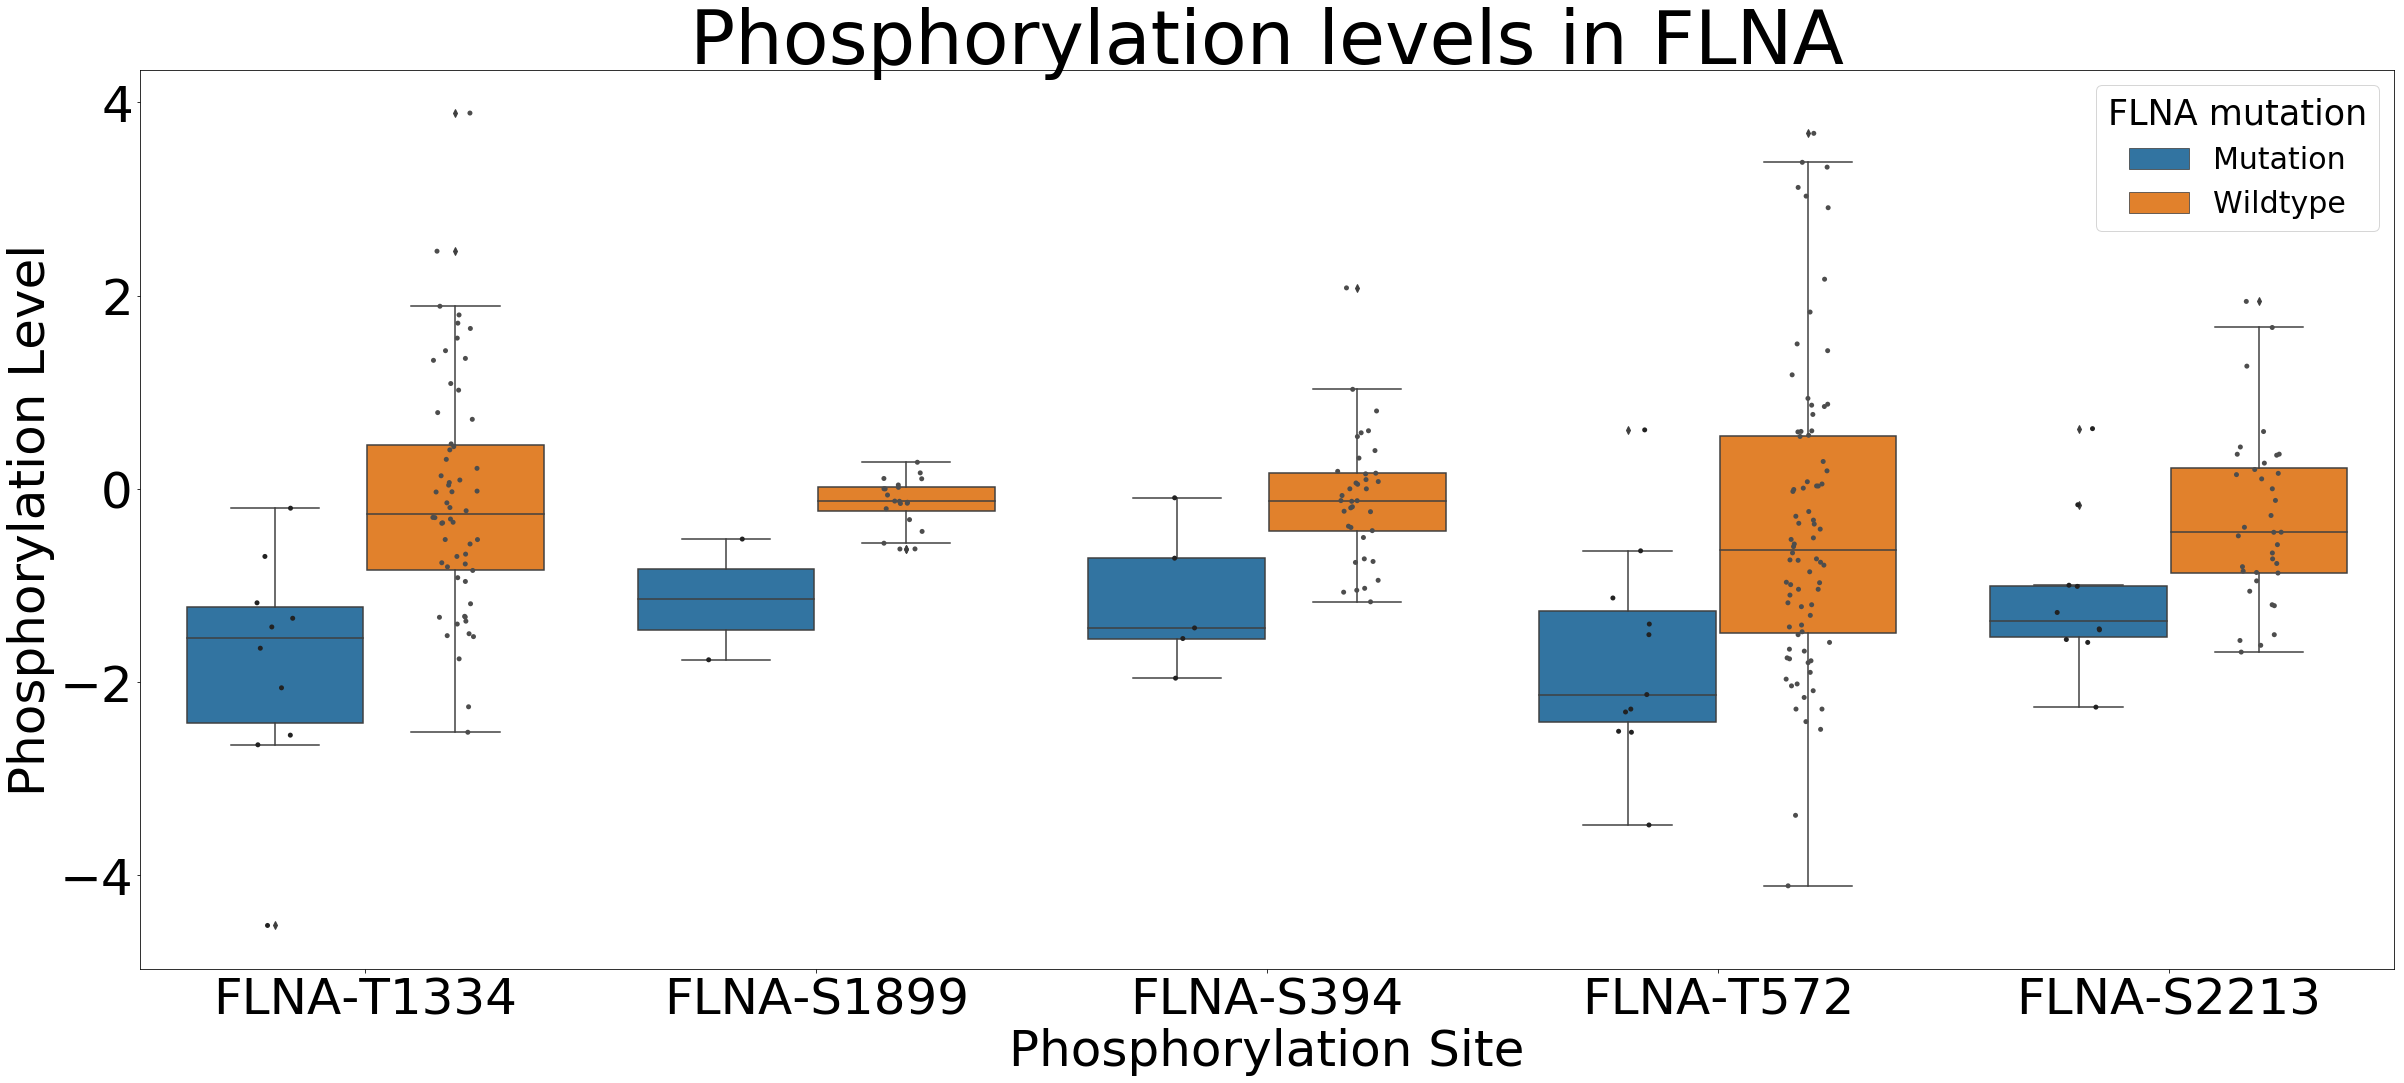

In [15]:
gene = 'FLNA'
prot = 'FLNA'

genedf = CPTAC.compare_mutations(phos, prot, gene)

p_val_dict = {}
siteList = []

'''Make a list of all sites with the associated protein'''
for colName in genedf:
    if colName != "Mutation" and colName != "Patient_Type":
        siteList.append(colName)


'''Do a t-test on each site, comparing mutated vs wildtype phosphorylation levels'''
for site in siteList:
    phosdf = CPTAC.compare_mutations(phos, site, gene)
    phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1).dropna()
    #print(phosdf)
    mutateddf = phosdf.loc[phosdf['Mutation'] != 'Wildtype']
    wtdf = phosdf.loc[phosdf['Mutation'] == 'Wildtype']
    ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
    p_val_dict[site] = ttest[1]   
#print(p_val_dict)

'''Remove nan p-values'''
for key in list(p_val_dict.keys()):
    if np.isnan(p_val_dict[key]):
        del p_val_dict[key]
        

'''Sort the dictionary for most significant p-values'''
sorted_dict = dict(sorted(p_val_dict.items(), key=lambda kv: kv[1]))
#print(sorted_dict)


'''Get the 5 most significant sites'''
five_most_sig_sites = []
for key in sorted_dict.keys():
    five_most_sig_sites.append(key)
five_most_sig_sites = five_most_sig_sites[:5]
#print(five_most_sig_sites)


'''Make a dataframe showing phosphorylation levels at these 5 sites, comparing mutated vs wildtype'''
plotdf = CPTAC.compare_mutations(phos, gene)
plotdf = plotdf.loc[plotdf['Patient_Type'] == 'Tumor'][['Mutation']]
for site in five_most_sig_sites:
    pdf = CPTAC.compare_mutations(phos, site, gene)[[site]]
    #print(proteindf)
    plotdf = plotdf.join(pdf)


'''Make all mutations read "mutation", to compare with wildtype'''
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Mutation',
                                      'Frame_Shift_Ins': 'Mutation',
                                      'Splice_Site' : 'Mutation',
                                      'In_Frame_Del' : 'Mutation',
                                      'Nonsense_Mutation': 'Mutation',
                                      'Missense_Mutation': 'Mutation'
                                     }})
    
'''Reformat dataframe to plot'''
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Site', value_name='Phosphorylation')
plotdf = plotdf.dropna(axis=0)
#print(plotdf)

'''Plot data'''
a4_dims = (40.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
boxplt = sns.boxplot(x='Site', y='Phosphorylation', hue='Mutation', data=plotdf)
boxplt = sns.stripplot(data=plotdf, x='Site', y='Phosphorylation', hue='Mutation', dodge=True, jitter=True, color='.3')

boxplt.set_xlabel('Phosphorylation Site', fontsize='50')
boxplt.set_ylabel('Phosphorylation Level', fontsize='50')
boxplt.tick_params(labelsize='50')
boxplt.set_title('Phosphorylation levels in ' + gene, fontsize = '75')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2],labels[0:2],title=gene + ' mutation', fontsize='30')
boxplt.get_legend().get_title().set_fontsize('35')

## ADD3

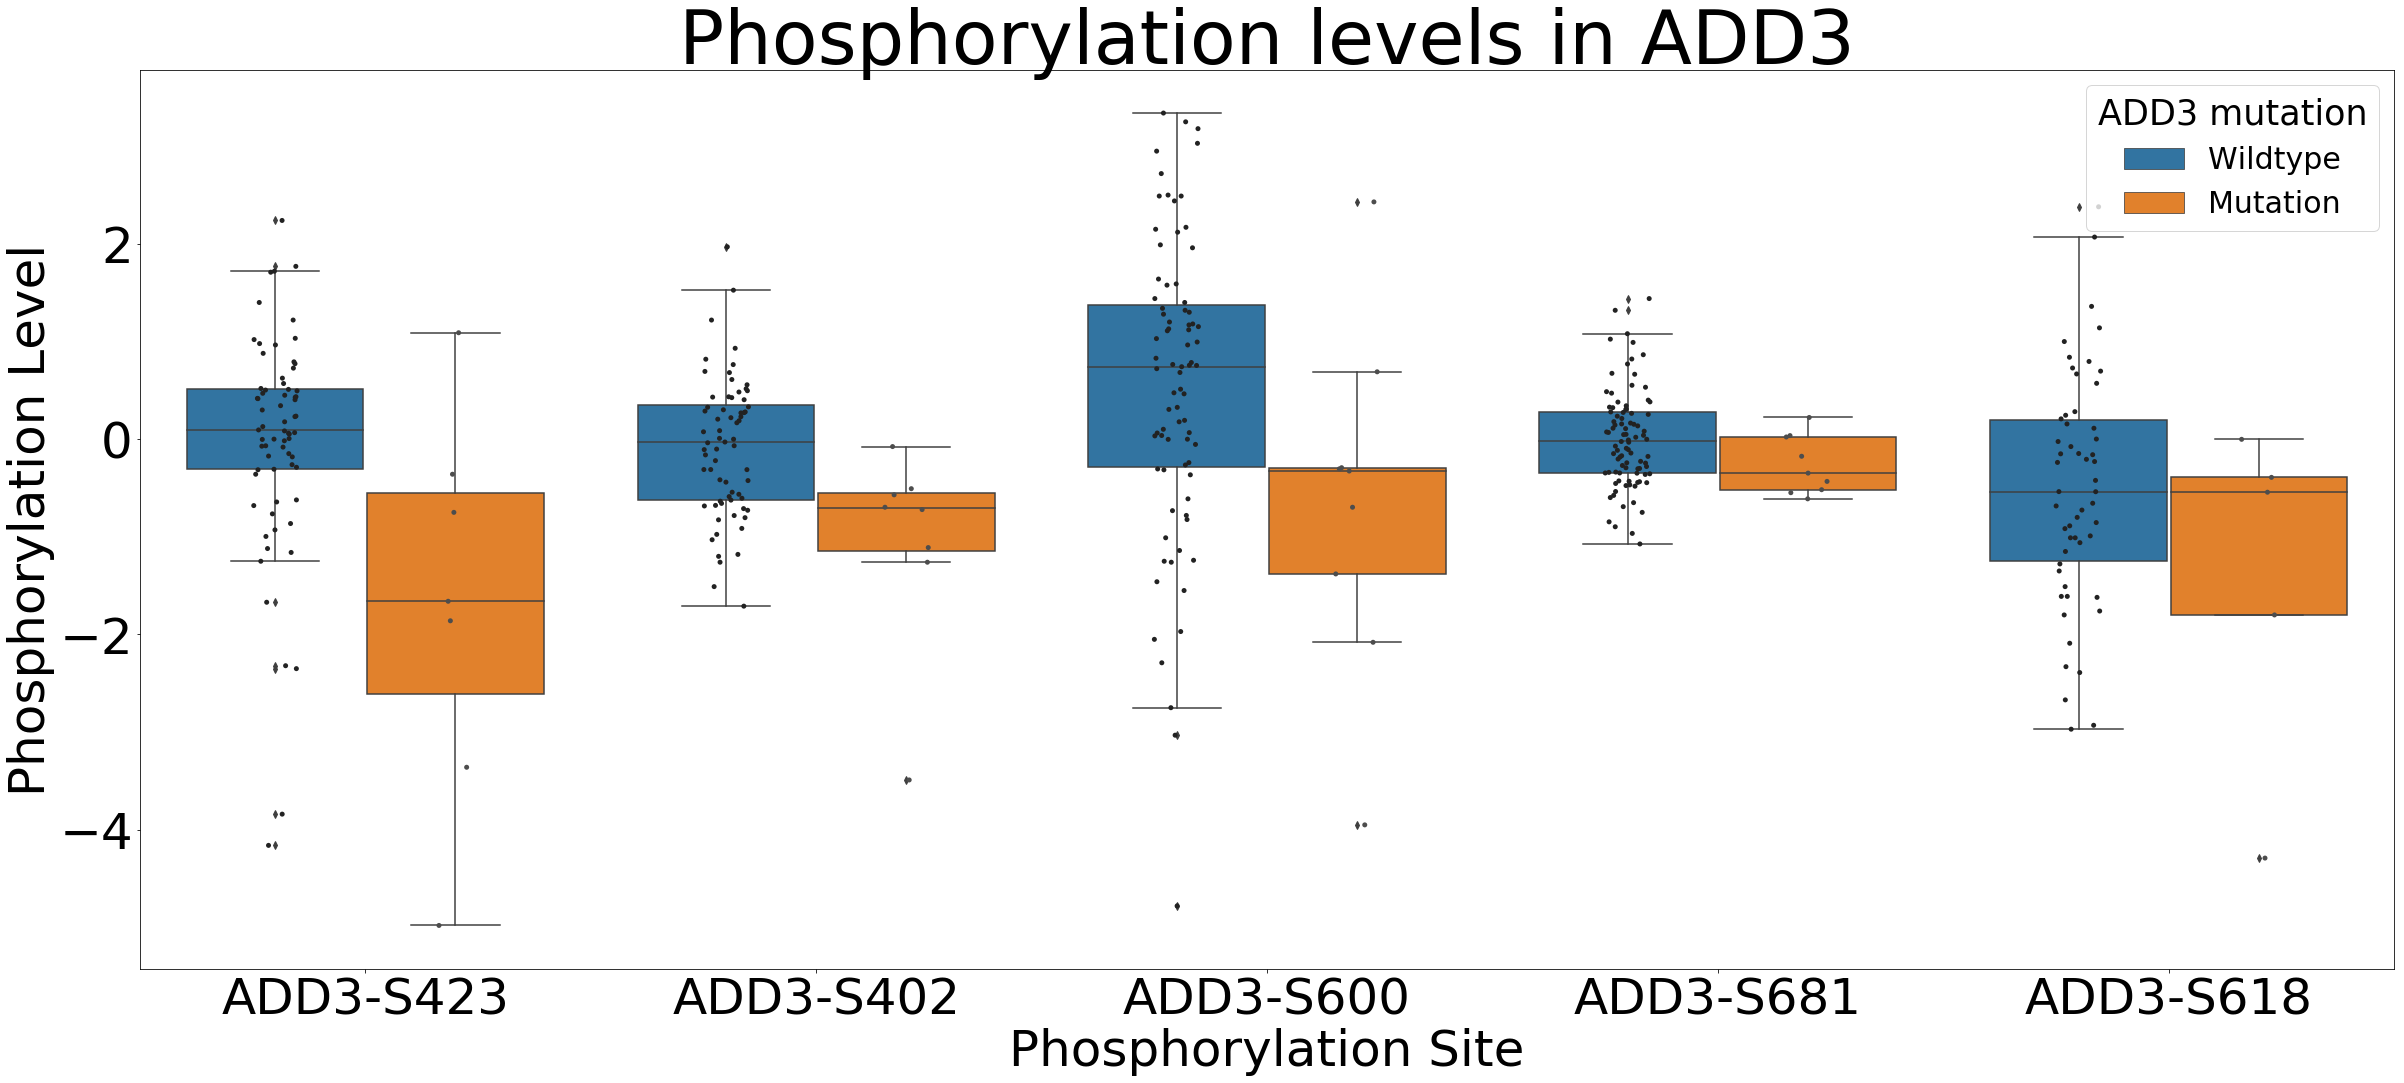

In [16]:
gene = 'ADD3'
prot = 'ADD3'

genedf = CPTAC.compare_mutations(phos, prot, gene)

p_val_dict = {}
siteList = []

'''Make a list of all sites with the associated protein'''
for colName in genedf:
    if colName != "Mutation" and colName != "Patient_Type":
        siteList.append(colName)


'''Do a t-test on each site, comparing mutated vs wildtype phosphorylation levels'''
for site in siteList:
    phosdf = CPTAC.compare_mutations(phos, site, gene)
    phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1).dropna()
    #print(phosdf)
    mutateddf = phosdf.loc[phosdf['Mutation'] != 'Wildtype']
    wtdf = phosdf.loc[phosdf['Mutation'] == 'Wildtype']
    ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
    p_val_dict[site] = ttest[1]   
#print(p_val_dict)

'''Remove nan p-values'''
for key in list(p_val_dict.keys()):
    if np.isnan(p_val_dict[key]):
        del p_val_dict[key]
        

'''Sort the dictionary for most significant p-values'''
sorted_dict = dict(sorted(p_val_dict.items(), key=lambda kv: kv[1]))
#print(sorted_dict)


'''Get the 5 most significant sites'''
five_most_sig_sites = []
for key in sorted_dict.keys():
    five_most_sig_sites.append(key)
five_most_sig_sites = five_most_sig_sites[:5]
#print(five_most_sig_sites)


'''Make a dataframe showing phosphorylation levels at these 5 sites, comparing mutated vs wildtype'''
plotdf = CPTAC.compare_mutations(phos, gene)
plotdf = plotdf.loc[plotdf['Patient_Type'] == 'Tumor'][['Mutation']]
for site in five_most_sig_sites:
    pdf = CPTAC.compare_mutations(phos, site, gene)[[site]]
    #print(proteindf)
    plotdf = plotdf.join(pdf)


'''Make all mutations read "mutation", to compare with wildtype'''
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Mutation',
                                      'Frame_Shift_Ins': 'Mutation',
                                      'Splice_Site' : 'Mutation',
                                      'In_Frame_Del' : 'Mutation',
                                      'Nonsense_Mutation': 'Mutation',
                                      'Missense_Mutation': 'Mutation'
                                     }})
    
'''Reformat dataframe to plot'''
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Site', value_name='Phosphorylation')
plotdf = plotdf.dropna(axis=0)
#print(plotdf)

'''Plot data'''
a4_dims = (40.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
boxplt = sns.boxplot(x='Site', y='Phosphorylation', hue='Mutation', data=plotdf)
boxplt = sns.stripplot(data=plotdf, x='Site', y='Phosphorylation', hue='Mutation', dodge=True, jitter=True, color='.3')

boxplt.set_xlabel('Phosphorylation Site', fontsize='50')
boxplt.set_ylabel('Phosphorylation Level', fontsize='50')
boxplt.tick_params(labelsize='50')
boxplt.set_title('Phosphorylation levels in ' + gene, fontsize = '75')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2],labels[0:2],title=gene + ' mutation', fontsize='30')
boxplt.get_legend().get_title().set_fontsize('35')

## CTNNB1

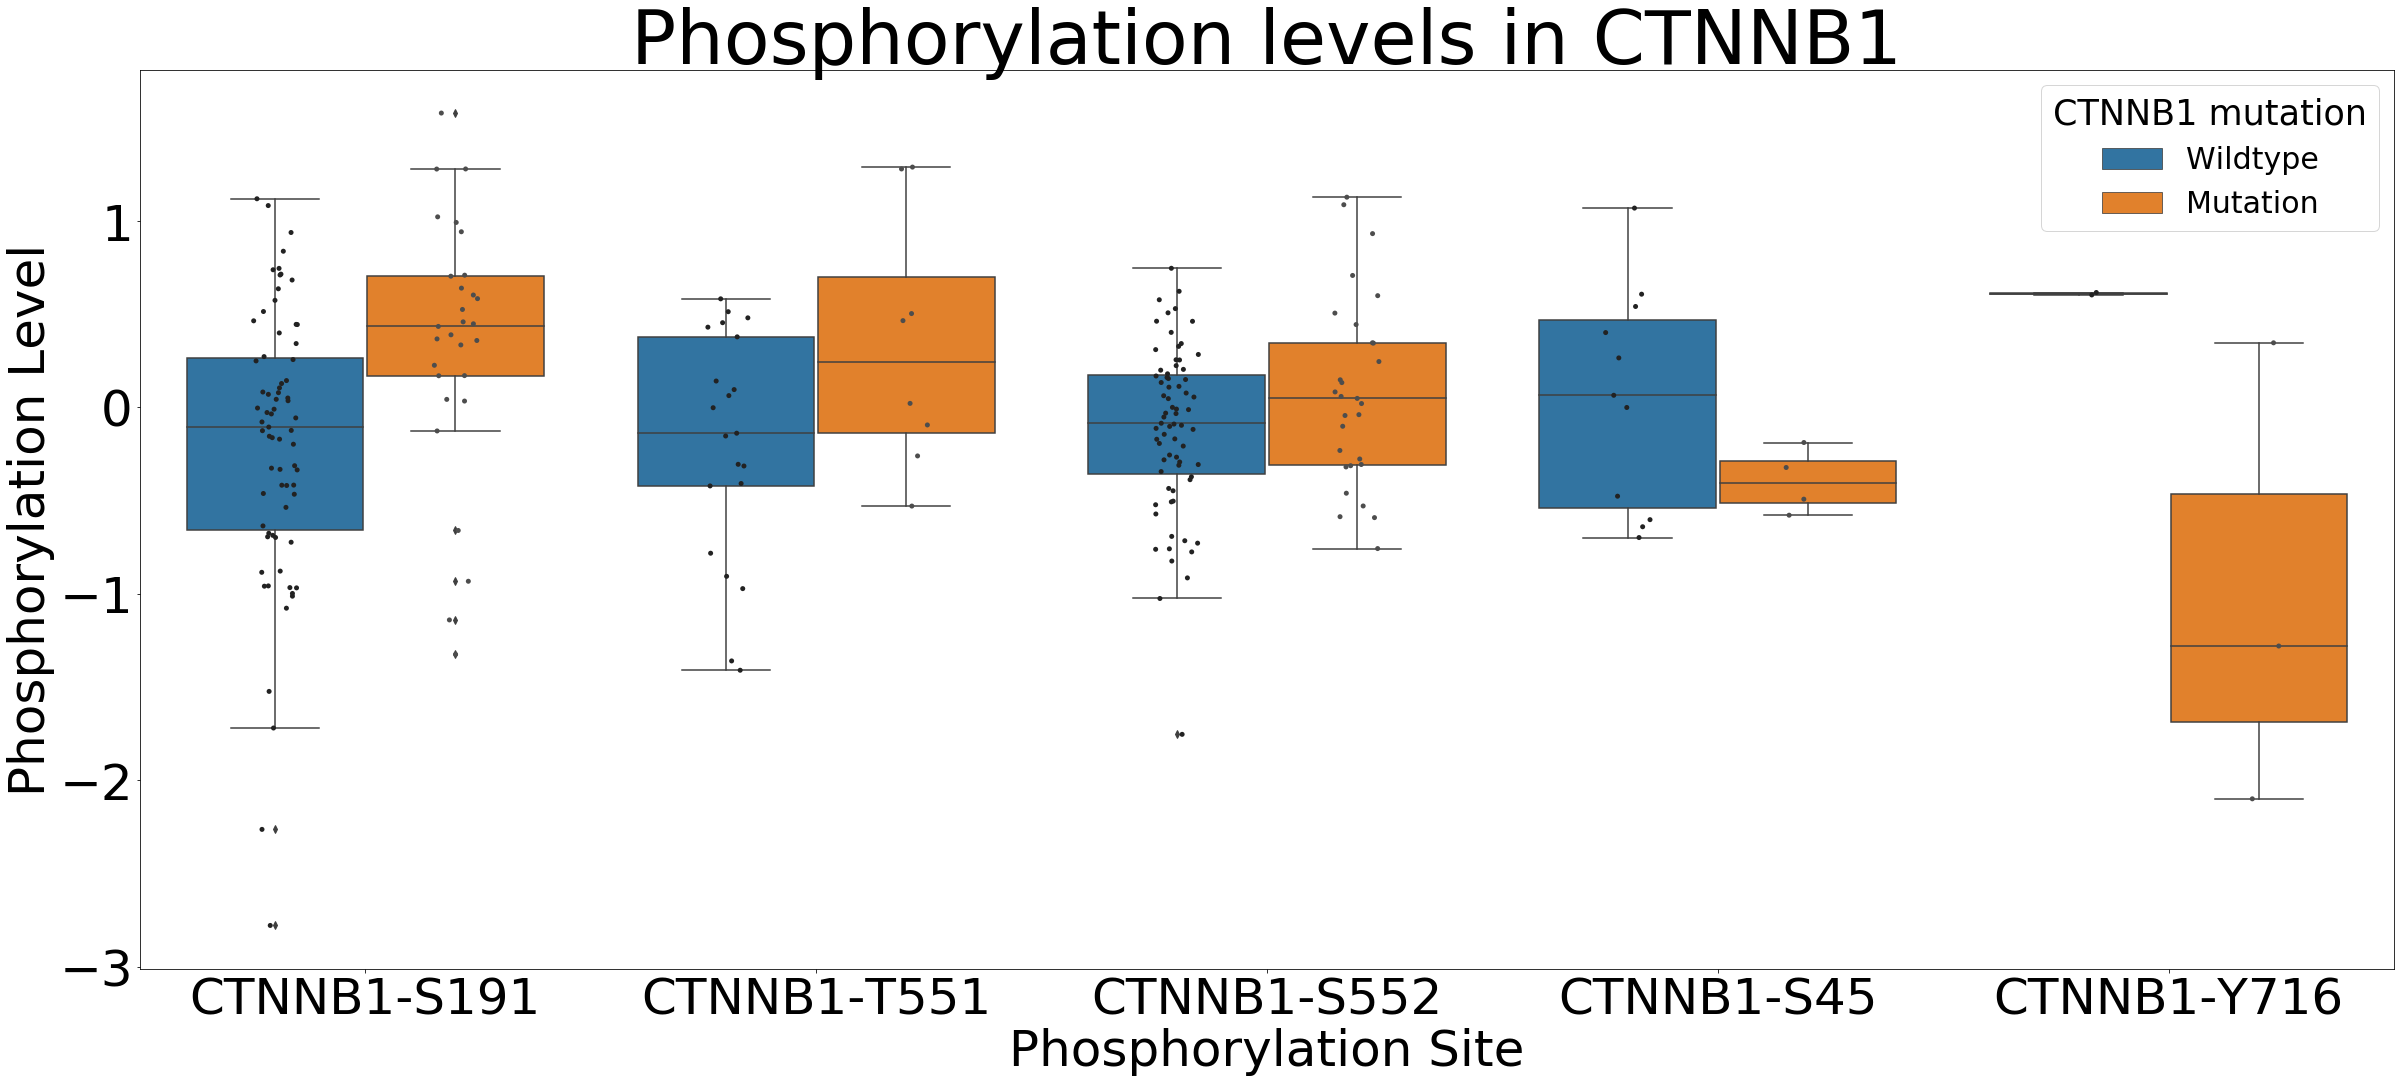

In [17]:
gene = 'CTNNB1'
prot = 'CTNNB1'

genedf = CPTAC.compare_mutations(phos, prot, gene)

p_val_dict = {}
siteList = []

'''Make a list of all sites with the associated protein'''
for colName in genedf:
    if colName != "Mutation" and colName != "Patient_Type":
        siteList.append(colName)


'''Do a t-test on each site, comparing mutated vs wildtype phosphorylation levels'''
for site in siteList:
    phosdf = CPTAC.compare_mutations(phos, site, gene)
    phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1).dropna()
    #print(phosdf)
    mutateddf = phosdf.loc[phosdf['Mutation'] != 'Wildtype']
    wtdf = phosdf.loc[phosdf['Mutation'] == 'Wildtype']
    ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
    p_val_dict[site] = ttest[1]   
#print(p_val_dict)

'''Remove nan p-values'''
for key in list(p_val_dict.keys()):
    if np.isnan(p_val_dict[key]):
        del p_val_dict[key]
        

'''Sort the dictionary for most significant p-values'''
sorted_dict = dict(sorted(p_val_dict.items(), key=lambda kv: kv[1]))
#print(sorted_dict)


'''Get the 5 most significant sites'''
five_most_sig_sites = []
for key in sorted_dict.keys():
    five_most_sig_sites.append(key)
five_most_sig_sites = five_most_sig_sites[:5]
#print(five_most_sig_sites)


'''Make a dataframe showing phosphorylation levels at these 5 sites, comparing mutated vs wildtype'''
plotdf = CPTAC.compare_mutations(phos, gene)
plotdf = plotdf.loc[plotdf['Patient_Type'] == 'Tumor'][['Mutation']]
for site in five_most_sig_sites:
    pdf = CPTAC.compare_mutations(phos, site, gene)[[site]]
    #print(proteindf)
    plotdf = plotdf.join(pdf)


'''Make all mutations read "mutation", to compare with wildtype'''
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Mutation',
                                      'Frame_Shift_Ins': 'Mutation',
                                      'Splice_Site' : 'Mutation',
                                      'In_Frame_Del' : 'Mutation',
                                      'Nonsense_Mutation': 'Mutation',
                                      'Missense_Mutation': 'Mutation'
                                     }})
    
'''Reformat dataframe to plot'''
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Site', value_name='Phosphorylation')
plotdf = plotdf.dropna(axis=0)
#print(plotdf)

'''Plot data'''
a4_dims = (40.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
boxplt = sns.boxplot(x='Site', y='Phosphorylation', hue='Mutation', data=plotdf)
boxplt = sns.stripplot(data=plotdf, x='Site', y='Phosphorylation', hue='Mutation', dodge=True, jitter=True, color='.3')

boxplt.set_xlabel('Phosphorylation Site', fontsize='50')
boxplt.set_ylabel('Phosphorylation Level', fontsize='50')
boxplt.tick_params(labelsize='50')
boxplt.set_title('Phosphorylation levels in ' + gene, fontsize = '75')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2],labels[0:2],title=gene + ' mutation', fontsize='30')
boxplt.get_legend().get_title().set_fontsize('35')